## Imports

In [29]:
from typing import Callable

import torch
import numpy as np
import plotly.io as pio
import plotly.express as px
from torch.optim import AdamW
from rich.progress import track
from pandas import DataFrame as DF
from torch.utils import data as torch_data
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader as DL
from torch.optim.lr_scheduler import ExponentialLR, LRScheduler, OneCycleLR

from models import mk_model
from datasets import TrainValidationPreprocessedOpenFWI as OpenFWIDataset

# Make the plotly plots (mostly) renderable on github.
pio.renderers.default = "jupyterlab+png"

## Datasets and data loaders

In [30]:
train_dataset = OpenFWIDataset("train")
train_loader = torch_data.DataLoader(train_dataset, batch_size=512, shuffle=True)

Output()

920


Output()

In [31]:
validation_dataset = OpenFWIDataset("validation")
validation_loader = torch_data.DataLoader(train_dataset, batch_size=1024, shuffle=True)

Output()

20


Output()

## Training

### Definitions

In [38]:
from rich.progress import Progress, Task
from torch import isnan, isinf

def fit(epochs:int,
        model: torch.nn.Module,
        scheduler: LRScheduler,
        optimizer: torch.optim.Optimizer,
        train_loader: DL,
        evaluation_func: callable=None,
    ) -> DF:
    scaler = GradScaler(device="cuda")
    metrics: list[dict] = []
    for epoch in range(epochs):
        total_epoch_loss = 0
        nb_samples = 0
        with Progress() as progress:
            task: Task = progress.add_task(f"epoch: {epoch + 1}, batch_loss: ...", total=len(train_loader))

            step = 0
            for x, y in train_loader:
                # forward
                x = (x.cuda() - train_dataset.stats["x_mean"]) / train_dataset.stats["x_std"]
                y = (y.cuda() - train_dataset.stats["y_mean"]) / train_dataset.stats["y_std"]
                nb_samples += len(x)
                model.train()
                optimizer.zero_grad()
                with autocast(device_type="cuda"):
                    y_pred = model(x)
                loss_value = (y_pred - y).abs().mean()

                if isnan(loss_value).item() or isinf(loss_value).item():
                    print("Warning: Got NaN loss, something went wring.")
                    return DF.from_records(metrics) 
                # backward
                scaler.scale(loss_value).backward()
                # scaler.unscale_(optimizer)
                # optional grad clipping ?
                scaler.step(optimizer)
                scaler.update()
                if step:
                    scheduler.step()
                # metrics
                # print(loss_value.item())
                total_epoch_loss += loss_value.item()
                metrics.append({
                    "step": step,
                    "epoch": epoch,
                    "batch_train_loss": loss_value.item(),
                    "lr": optimizer.state_dict()["param_groups"][-1]["lr"],
                })
                progress.update(task, advance=1, description=f"epoch: {epoch}, batch_loss: {loss_value.item():.4f}")

                step += 1
                
        metrics[-1]["train_epoch_loss"] = total_epoch_loss / len(train_loader)
        progress.console.print(f"train loss:", metrics[-1]["train_epoch_loss"])
        if evaluation_func:
            eval_metrics = evaluation_func()
            metrics[-1].update(eval_metrics)
            progress.console.print(f"validation loss:", metrics[-1]["validation_loss"])
        
    return DF.from_records(metrics)

### Find lr

#### Run mock training

In [33]:
MOCK_TRAINING_EPOCHS = 5
STARTING_LR = 1e-5

mock_model = mk_model()
mock_optim = AdamW(mock_model.parameters(), lr=STARTING_LR)
mock_training_metrics = fit(
    epochs=MOCK_TRAINING_EPOCHS,
    model=mock_model,
    optimizer=mock_optim,
    scheduler=ExponentialLR(mock_optim, 1.01),
    train_loader=train_loader,
)
mock_training_metrics = (
    mock_training_metrics
    .query("batch_train_loss.notna()")
    .set_index("lr")
)

Output()

train loss: 0.3853284519692019

Output()

Warning: Got NaN loss, something went wring.

#### Visualize smoothed loss over learning rate

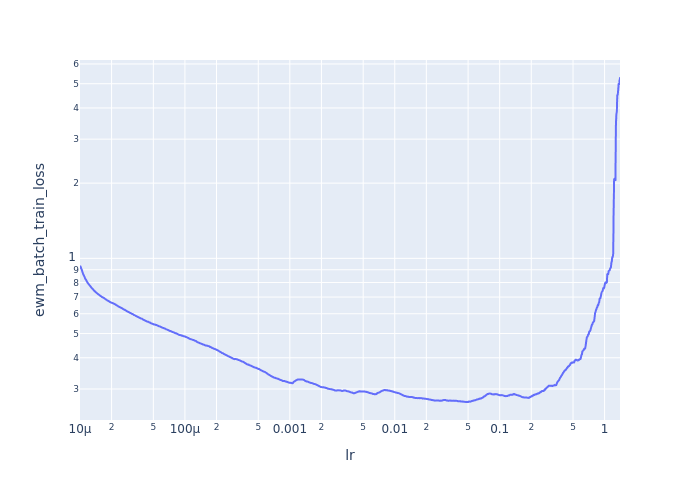

In [34]:
mock_training_metrics["ewm_batch_train_loss"] = (
    mock_training_metrics
    .ewm(com=30, ignore_na=False)
    ["batch_train_loss"]
    .mean()
)

px.line(
    mock_training_metrics,
    y="ewm_batch_train_loss",
    log_x=True,
    log_y=True
)

### Fit model

In [35]:
def evaluate_model(model: torch.nn.Module, critirion=torch.nn.L1Loss()) -> dict:
    
    model = model.eval()
    
    total_test_loss = 0
    for x, y in track(validation_loader, description="evaluating..."):
        x = (x.cuda() - train_dataset.stats["x_mean"]) / train_dataset.stats["x_std"]
        y = (y.cuda() - train_dataset.stats["y_mean"]) / train_dataset.stats["y_std"]
        with autocast("cuda"), torch.no_grad():
            y_pred = model(x)
        total_test_loss += critirion(y_pred, y).item()
    total_test_loss /= len(validation_loader)
        
    return {"validation_loss": total_test_loss}

# evaluate_model(mk_model())

In [40]:
max_lr = mock_training_metrics["ewm_batch_train_loss"].idxmin()
max_lr


TRAINING_EPOCHS = 16
STEPS_PER_EPOCH = len(mock_training_metrics.query("epoch == 0"))

model = mk_model()
optimizer = AdamW(model.parameters(), lr=max_lr)

In [ ]:
scheduler = OneCycleLR(
    optimizer,
    max_lr,
    epochs=TRAINING_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)
training_metrics = fit(
    TRAINING_EPOCHS,
    model,
    scheduler,
    optimizer,
    train_loader,
    lambda :evaluate_model(model)
)

Output()

#### Visualize loss over training steps

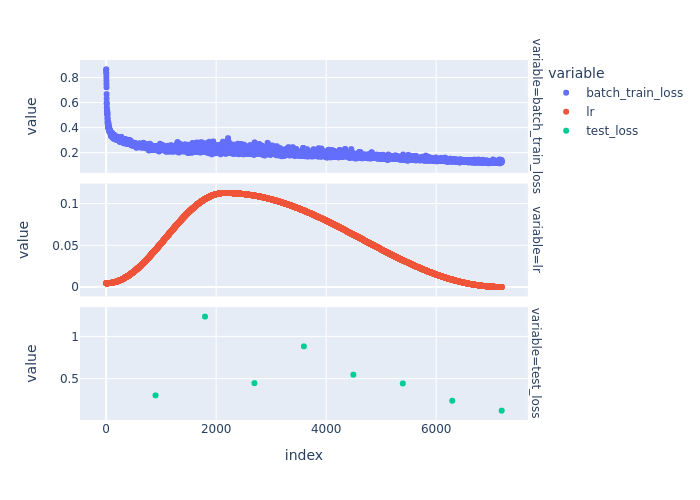

In [ ]:
px.scatter(
    (
        training_metrics
        .reset_index()
        .melt(
            id_vars="index",
            value_vars=["batch_train_loss", "lr", "test_loss"],
        )
    ),
    x="index",
    y="value",
    color="variable",
    facet_row="variable",
    render_mode='lines+markers',
).update_yaxes(matches=None)

#### Save model

In [ ]:
from os.path import join
from datetime import datetime

! mkdir -p "models"
date = datetime.now().strftime("%d-%m-%Y_%H-%M")
model_name = f"{date}_{TRAINING_EPOCHS}_epohcs_{max_lr:.3f}_max_lr.pth" 
model_path = join("models", model_name)
torch.save(model.state_dict(), model_path)
!ln -sf "{model_path}" models/latest_model.pth

## Visualize trained model's outputs

train


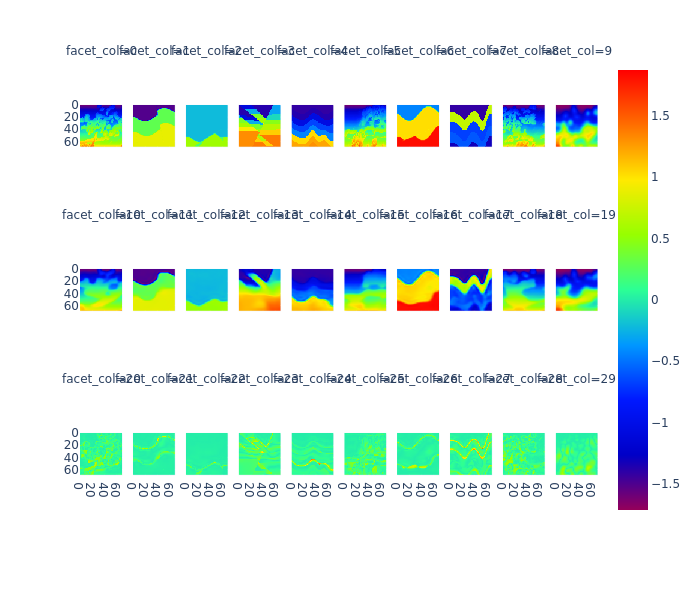

test


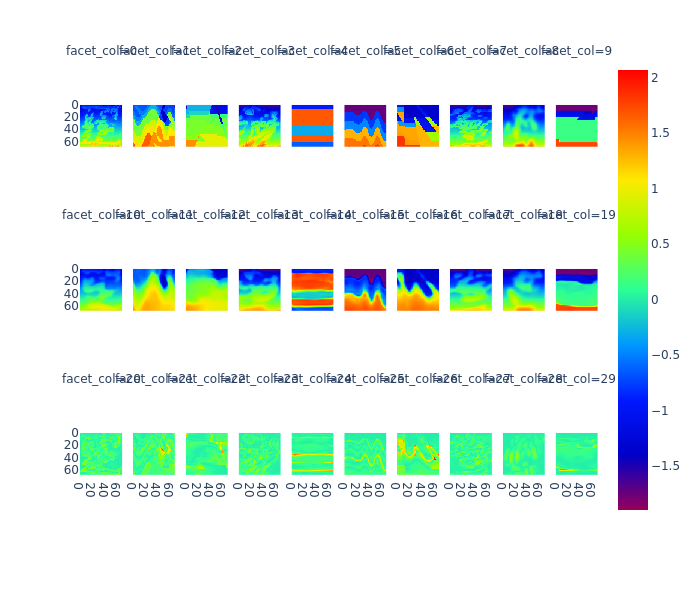

In [ ]:
OFFSET = 50
IMGS_TO_SHOW = 10

def viz_model_outputs(data_loader: DL):
    x, y = next(iter(data_loader))
    x = (x - train_dataset.stats["x_mean"]) / train_dataset.stats["x_std"]
    y = (y - train_dataset.stats["y_mean"]) / train_dataset.stats["y_std"]


    y_true_to_display = (
        y
        .cpu()
        .numpy()
        [OFFSET:OFFSET+IMGS_TO_SHOW, 0, ...]
    )
    with autocast("cuda"):
        y_pred = model(x.cuda())
    y_pred_to_display = (
        y_pred
        .cpu()
        .detach()
        .numpy()
        [OFFSET:OFFSET+IMGS_TO_SHOW, 0, ...]
    )

    px.imshow(
        np.concatenate((
            y_true_to_display,
            y_pred_to_display,
            np.abs(y_pred_to_display - y_true_to_display), # Absolute loss
        )),
        facet_col=0,
        facet_col_wrap=IMGS_TO_SHOW,
        color_continuous_scale="Rainbow",
        height=600,
    ).show()

print('train')
viz_model_outputs(train_loader)
print('test')
viz_model_outputs(validation_loader)